Copyright 2022 Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.

# Crossvalidation and Nested crossvalidation

The goal of all models we build is to **predict** and **generalize**.
If our model only works for the data we train it on, and doesn't work for anything else, it's not a very useful model.

One way to test generalization is to split the data into training and testing data.
The training data is used to estimate the model's parameters, and the testing data is used to determine how much we can trust the model's predictions on unseen data.
If the performance of the model is very good on the training data but very poor on the testing data, we say that the model has **overfit** the training data.
If the model's performance on the testing data is as good or better than the training data, then we conclude that the model will generalize well.

But what if we're wrong?
What if we got lucky with a train/test split, such that the testing data is "easy" and very similar to the training data?
One way to increase our confidence is to train and test **repeatedly with different train/test splits**.
But again, we have a problem: what if our train/test splits overlap substantially?
We only get more information about model performance if the splits are different, not when they are the same.

### What you will learn

In this notebook you will learn about methods to avoid overfit during training and to increase our confidence in model generalization. We will study the following:

- Crossvalidation
- Nested crossvalidation

### When to use crossvalidation

It's generally recommended to use crossvalidation in standard practice, rather than a single train/test split.
Fortunately crossvalidation is so common that many data science frameworks make it relatively easy to use.
An important consideration is what evaluation metrics mean when models are trained with crossvalidation, so keep evaluation metrics in mind as you progress through this notebook.

## Crossvalidation

**Crossvalidation** is a fairly simple yet elegant idea that solves these problems.
Crossvalidation lets us use **all** our data for both training and testing, by partitioning it in separate sets, typically called **folds**. 

Figure 1 shows all the data split into 5 folds.
Crossvalidation training would create five models using these five folds, such that each model uses a different fold for testing (blue).
All the other folds are used for training.
For example, one model would use fold 1 for testing and folds 2-5 for training.

<!-- 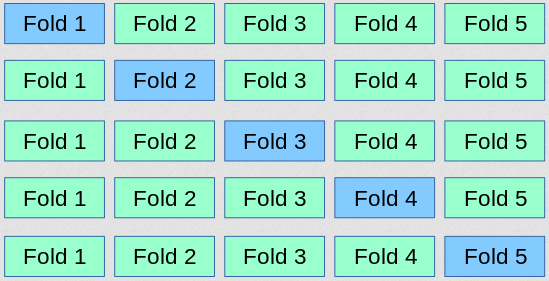 -->
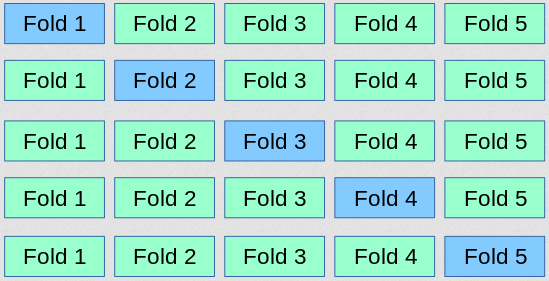
<center><b>Figure 1. Crossvalidation with five folds.</b> Source: <a href="https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation">Adapted from scikit-learn</a></center>

Using crossvalidation, all data is used for both training and testing **but not at the same time.**
This allows us to train with all the data without worrying about overfitting. 
It also lets us robustly test generalization because we've used all the data for testing as well.

Crossvalidation works nicely with all of the standard peformance metrics like $r^2$, accuracy, and precision/recall: because the predictions from separate models are on separate folds, we can calculate performance metrics as though the predictions came from a single model.
Alternatively, we can calculate performance on each fold separately to get a distribution of performance.

Finally, you might see the connections between crossvalidation and out-of-bag (OOB) error with bagging.
Crossvalidation could be viewed as a generalization of OOB, since crossvalidation can be used with any model.
Crossvalidation is also a simplification over OOB, since OOB requires keeping track of which aggregated models are "allowed" to make a prediction on a datapoint, whereas in crossvalidation, a single model makes predictions on its test fold, and that's it.

## Example: Crossvalidation

Let's take a look at the `iris` dataset, which consists of measurements of sepals and petals, as well as the class label for three species of iris.

| Variable                 | Type    | Description                                                                    |                                |
|:--------------------------|:---------|:--------------------------------------------------------------------------------|--------------------------------|
| Sepal Length             | Ratio   | Length of the leaves that support the petals                                    |                                |
| Sepal Width              | Ratio   | Width of the leaves that suppotr the petals                                     |                                |
| Petal Length             | Ratio   | Length of petals                                                               |                                |
| Petal Width              | Ratio   | Width of petals                                                                |                                |
| Species                  | Nominal     | Setosa, Versicolour, Virginica |     

<div style="text-align:center;font-size: smaller">
 <b>Source:</b> This dataset was taken from the <a href="https://archive.ics.uci.edu/ml/datasets/iris">UCI Machine Learning Repository library
    </a></div>
<br>

**Because this is a familiar dataset, and because the focus is on crossvalidation, we will skip data exploration steps and go quickly to modeling.**

### Load data

Start by loading `readr`, `dplyr`, and `base` so we can read data into a dataframe and manipulate it:

- `library readr`
- `library dplyr`
- `library base`

In [144]:
library(readr)
library(dplyr)
library(base)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable></variables><block type="import_R" id="q]np1Ju|B`4k*R-zylwU" x="44" y="66"><field name="libraryName" id="_;PP-/]_2fNUR.dyhw(8">readr</field><next><block type="import_R" id="(%@0XC,((6M%4]kj+iDm"><field name="libraryName" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><next><block type="import_R" id="AmB3B[T@UHq1l2P*NjUF"><field name="libraryName" id="6C!l+@S8,SvtzakmsxQD">base</field></block></next></block></next></block></xml>

Load the dataframe using a CSV file:

- Set `dataframe` to
    - `with readr do read_csv`
        - using `"datasets/iris.csv"`
         - and `col_types =` `create list with`
        - `Species = col_factor(c("setosa","virginica","versicolor"))`
        
- `dataframe` (to display)

In [145]:
dataframe = readr::read_csv("datasets/iris.csv",col_types= list(Species = col_factor(c("setosa","virginica","versicolor"))))

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable></variables><block type="variables_set" id="gM*jw`FfIR3)8=g0iEB7" x="-102" y="28"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id=",vaW{t?FHN1~E?+,h!w-"><mutation items="2"></mutation><field name="VAR" id="_;PP-/]_2fNUR.dyhw(8">readr</field><field name="MEMBER">read_csv</field><data>readr:read_csv</data><value name="ADD0"><block type="text" id="dfrpI5b@DHr+DQ:|@vpv"><field name="TEXT">datasets/iris.csv</field></block></value><value name="ADD1"><block type="valueOutputCodeBlock_R" id="{vpWbZpifS]W[4(3|ZZO"><field name="CODE">col_types=</field><value name="INPUT"><block type="lists_create_with" id="gMk-JHtz6$`^i`U@hJ!{"><mutation items="1"></mutation><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="N!~T8Xfb2}FBuK#~ue?N"><field name="CODE">Species = col_factor(c("setosa","virginica","versicolor"))</field></block></value></block></value></block></value></block></value></block><block type="variables_get" id="dn{+Q#DO%lN;G_tFGJ#B" x="-114" y="118"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></xml>

SepalLength,SepalWidth,PetalLength,PetalWidth,Species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
⋮,⋮,⋮,⋮,⋮
6.8,3.2,5.9,2.3,virginica


### Prepare train/test sets

We need to split the dataframe into training data and testing data.

First, load the package for splitting:

- `library rsample`

In [146]:
library(rsample)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable></variables><block type="import_R" id="aFBwKpYz$V@3rI9Nk71a" x="-280" y="10"><field name="libraryName" id="~~-I(f=60)#JfKGvV_AP">rsample</field></block></xml>

Now split the data, but first specify a random seed so your results match mine :
           
- with `base` do `set.seed` using `2`

- Set `data_split` to `with rsample do initial split`
    - using `dataframe`
    - and `prop=.80`
- Set `data_train` to `with rsample do training`
    - using `data_split`
- Set `data_test` to `with rsample do testing`
    - using `data_split`
- `data_train`


In [147]:
base::set.seed(2)

data_split = rsample::initial_split(dataframe,prop=.80)
data_train = rsample::training(data_split)
data_test = rsample::testing(data_split)

data_train

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="bQ!4E:J!~]0(]7KV]m@=">data_split</variable><variable id=":iMr},W7(N7vSLAUw!ao">data_train</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="varDoMethod_R" id="Bs.?L_yk:!JU:!D9$e:2" x="-110" y="151"><mutation items="1"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">set.seed</field><data>base:set.seed</data><value name="ADD0"><block type="math_number" id="y3|#H:ii-(np[L}nH,7)"><field name="NUM">2</field></block></value></block><block type="variables_set" id="s!g),aa^(]dox/f`@P!y" x="-116" y="302"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field><value name="VALUE"><block type="varDoMethod_R" id="hPsr6}9C/VNgaLsKuR,o"><mutation items="2"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">initial_split</field><data>rsample:initial_split</data><value name="ADD0"><block type="variables_get" id="]~#@ltf];dTom_%pzV4n"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="R`?vH79hsA6Duxa9)AFX"><field name="CODE">prop=.80</field></block></value></block></value><next><block type="variables_set" id="3J6#JDFV0wE?V;NuM=?L"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field><value name="VALUE"><block type="varDoMethod_R" id="X|Q7lj,pD_9W{%^.xd7h"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">training</field><data>rsample:training</data><value name="ADD0"><block type="variables_get" id="JFCmHyJPiN`qwnlE~:iT"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value></block></value><next><block type="variables_set" id="Y]ag(g~}tkN6:_X*]6P{"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field><value name="VALUE"><block type="varDoMethod_R" id="WBYo8G|ZcojJAqETRnv`"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">testing</field><data>rsample:testing</data><value name="ADD0"><block type="variables_get" id="p^~x9|Zj((6qaUVvj#.E"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value></block></value></block></next></block></next></block><block type="variables_get" id="9j){6[r67+7OFx`a~K[Y" x="-115" y="515"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field></block></xml>

SepalLength,SepalWidth,PetalLength,PetalWidth,Species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.4,3.0,4.5,1.5,versicolor
5.4,3.9,1.7,0.4,setosa
7.7,3.0,6.1,2.3,virginica
5.4,3.9,1.3,0.4,setosa
5.8,2.6,4.0,1.2,versicolor
6.7,3.3,5.7,2.1,virginica
5.0,3.5,1.3,0.3,setosa
⋮,⋮,⋮,⋮,⋮
6.2,2.2,4.5,1.5,versicolor


So far things have followed our standard practice.
This next step is where things change: we will make folds from the training data:

- Set `folds` to with `resample` do `vfold_cv`
    - using `data_train`
    - and `v = 10` (this specifies the number of folds)
    - and `strata="Species"` (so each fold has all levels of the target)
- `print` `folds`

*Note: `print` is used here to prevent pages of output from being displayed.*

In [148]:
folds = rsample::vfold_cv(data_train,v=10,strata="Species")

print(folds);

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Jf`Hc(Jw6)c^J2094GU-">folds</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id=":iMr},W7(N7vSLAUw!ao">data_train</variable></variables><block type="variables_set" id="fbB[H3;f3-u]ZOIN+1r=" x="-270" y="117"><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field><value name="VALUE"><block type="varDoMethod_R" id="rzcA-ECrv`a,x/6tPRRW"><mutation items="3"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">vfold_cv</field><data>rsample:vfold_cv</data><value name="ADD0"><block type="variables_get" id="I4A@g,F]E)99z=`g/TC{"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="9qXIO^)h[sQg,_kuOG[s"><field name="CODE">v=10</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="[8o:?WELg3[g*Ju=?#fi"><field name="CODE">strata="Species"</field></block></value></block></value></block><block type="text_print" id="OlAlA6O?w1qevz![p:YH" x="-269" y="347"><value name="TEXT"><shadow type="text" id="Aq_a5^(xlt.P2fX8{l/0"><field name="TEXT">abc</field></shadow><block type="variables_get" id="vAXKyb{NRE2oF~)4-*-{"><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field></block></value></block></xml>

#  10-fold cross-validation using stratification 
# A tibble: 10 × 2
   splits           id    
   <list>           <chr> 
 1 <split [107/13]> Fold01
 2 <split [108/12]> Fold02
 3 <split [108/12]> Fold03
 4 <split [108/12]> Fold04
 5 <split [108/12]> Fold05
 6 <split [108/12]> Fold06
 7 <split [108/12]> Fold07
 8 <split [108/12]> Fold08
 9 <split [108/12]> Fold09
10 <split [109/11]> Fold10


Each of these folds is a list of rows from the training data.

### Train model with crossvalidation

The most convenient way to use crossvalidation is from a workflow.

Load the `recipes` and `workflows` packages, along with `parsnip`, `generics`, `hardhat`, `discrim`, `yardstick`, `broom`, and a new package we need for crossvalidation, `tune`:

- `library recipes`
- `library workflows`
- `library parsnip`
- `library generics`
- `library hardhat`
- `library broom`
- `library discrim`
- `library tune`
- `library yardstick`

In [149]:
library(recipes)
library(workflows)
library(generics)
library(parsnip)
library(hardhat)
library(broom)
library(discrim)
library(tune)
library(yardstick)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="Ubl?FFCN5uCFfCTQ?7:z">broom</variable><variable id="w!D@.AsJTNGfyfT07ttG">discrim</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable></variables><block type="import_R" id="EGE;dT.cnN,o}Y[99#Qb" x="6" y="15"><field name="libraryName" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><next><block type="import_R" id="6DrE-26ByLD$vC}QeW:}"><field name="libraryName" id="haMDnc8Uj|EjY^608!;]">workflows</field><next><block type="import_R" id="hQ4(=]9%QB3(VWqs9OK:"><field name="libraryName" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><next><block type="import_R" id="d1vIIBH:{ygkVLV/Ts5l"><field name="libraryName" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><next><block type="import_R" id="vFfUgs[O$$~/VO1yVa~v"><field name="libraryName" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><next><block type="import_R" id="cegz.xTQ~Bq[q~wqZQHD"><field name="libraryName" id="Ubl?FFCN5uCFfCTQ?7:z">broom</field><next><block type="import_R" id="woT+;7kaSfjsFo7!kbL@"><field name="libraryName" id="w!D@.AsJTNGfyfT07ttG">discrim</field><next><block type="import_R" id="a@ke{uWOBz.cGHew5^bE"><field name="libraryName" id="P9;RzeN25v*`uh$NdfXd">tune</field><next><block type="import_R" id="w=n3fFxd6.xE]tegxU.u"><field name="libraryName" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field></block></next></block></next></block></next></block></next></block></next></block></next></block></next></block></next></block></xml>

Let's make a workflow to predict `Species` with naive Bayes.

- Set `recipe` to 
    - `pipe` with `recipes` do `recipe`
        - using `Species ~ .`
        - and `data = data_train`
- Set `model` to 
    - `pipe` with `parsnip` do `naive_Bayes` 
<!--         - using `smoothness = 1`
        - and `Laplace = .5` -->
    - to with `parsnip` do `set_mode` 
        - using `"classification"`
    - then to with `parsnip` do `set_engine`
        - using `"naivebayes"`
- Set `workflow` to 
    - `pipe` with `workflows` do `workflow`
    - to with `workflows` do `add_model`
        - using `model`
    - then to with `workflows` do `add_recipe` 
        - using `recipe`
        

In [150]:
recipe = recipes::recipe(Species ~ .,data = data_train)
model = parsnip::naive_Bayes() %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("naivebayes")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="-9" y="77"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Species ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="0"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">naive_Bayes</field><data>parsnip:naive_Bayes</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">naivebayes</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value></block></next></block></next></block></xml>

Again, setting up the workflow followed our standard practice.

However, fitting the workflow is different because it uses `folds`.
Additionally, we can conveniently pass a list of metrics we'd like calculated at the same time:

-  Set `trained_model` to with `tune` do `fit_resamples`
    - using `workflow`
    - and `data = data_train`
    - and `metrics = metric_set(accuracy,precision,recall,f_meas)`
- `print` `trained_model`

In [151]:
trained_model = tune::fit_resamples(workflow,folds,metrics = metric_set(accuracy,precision,recall,f_meas))

print(trained_model);

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="l#fwZ4WDUe#-#XAb#q^;">trained_model</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="Jf`Hc(Jw6)c^J2094GU-">folds</variable></variables><block type="variables_set" id="6F5Ls%m;fDN%1P.HL;~b" x="71" y="186"><field name="VAR" id="l#fwZ4WDUe#-#XAb#q^;">trained_model</field><value name="VALUE"><block type="varDoMethod_R" id="jAjgrG@)Vv]=~@dnuh7H"><mutation items="3"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">fit_resamples</field><data>tune:fit_resamples</data><value name="ADD0"><block type="variables_get" id="KB;+aD=xFzgUg0(`:xP:"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD1"><block type="variables_get" id="aya`SBf}Lk:]z8ag^F.."><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="bz)h/3#`$hofTtN;fElV"><field name="CODE">metrics = metric_set(accuracy,precision,recall,f_meas)</field></block></value></block></value></block><block type="text_print" id="[w|/Aw2$C]dKLjPTzE#Y" x="76" y="376"><value name="TEXT"><shadow type="text" id="?(8+~ekjrntJV@Bc@GvK"><field name="TEXT">abc</field></shadow><block type="variables_get" id="qJ0nFc9Y6f9.~_a8X@r6"><field name="VAR" id="l#fwZ4WDUe#-#XAb#q^;">trained_model</field></block></value></block></xml>

# Resampling results
# 10-fold cross-validation using stratification 
# A tibble: 10 × 4
   splits           id     .metrics         .notes          
   <list>           <chr>  <list>           <list>          
 1 <split [107/13]> Fold01 <tibble [4 × 4]> <tibble [0 × 3]>
 2 <split [108/12]> Fold02 <tibble [4 × 4]> <tibble [0 × 3]>
 3 <split [108/12]> Fold03 <tibble [4 × 4]> <tibble [0 × 3]>
 4 <split [108/12]> Fold04 <tibble [4 × 4]> <tibble [0 × 3]>
 5 <split [108/12]> Fold05 <tibble [4 × 4]> <tibble [0 × 3]>
 6 <split [108/12]> Fold06 <tibble [4 × 4]> <tibble [0 × 3]>
 7 <split [108/12]> Fold07 <tibble [4 × 4]> <tibble [0 × 3]>
 8 <split [108/12]> Fold08 <tibble [4 × 4]> <tibble [0 × 3]>
 9 <split [108/12]> Fold09 <tibble [4 × 4]> <tibble [0 × 3]>
10 <split [109/11]> Fold10 <tibble [4 × 4]> <tibble [0 × 3]>


Note the `.metrics` column, which contains metrics for each fold.

We can extract these metrics using `collect_metrics`:

In [152]:
tune::collect_metrics(trained_model)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="l#fwZ4WDUe#-#XAb#q^;">trained_model</variable></variables><block type="varDoMethod_R" id="OSN?3w=qR8onK*l[9nH+" x="-268" y="152"><mutation items="1"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">collect_metrics</field><data>tune:collect_metrics</data><value name="ADD0"><block type="variables_get" id="oYkT|7-OYJm`eR@$Nrf;"><field name="VAR" id="l#fwZ4WDUe#-#XAb#q^;">trained_model</field></block></value></block></xml>

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.9673077,10,0.01335940,Preprocessor1_Model1
f_meas,macro,0.9661376,10,0.01382428,Preprocessor1_Model1
precision,macro,0.9733333,10,0.01088662,Preprocessor1_Model1
recall,macro,0.9666667,10,0.01360828,Preprocessor1_Model1


These are the results of crossvalidation on the training set, so we'd expect a model trained on the full training set would have similar performance as this when evaluated on the test set.

The workflow makes this pretty convenient to check out by letting us select the best model from our folds (according to whatever metric we set) and then fitting the model with *all* the training data and testing it on the test data:

- `pipe`
    - `workflow`
    - to with `tune` do `finalize_workflow`
        - using `pipe`
            - `trained_model`
            - to  with `tune` do `select_best`
                - using `"f_meas"`
    - then to with `tune` do `last_fit` using
        - `data_split`
        - `metrics = metric_set(accuracy,precision,recall,f_meas)`
    - then to with `tune` do `collect_metrics`
    
*Note: `finalize_workflow` anchors the workflow on the best model according to our specifications, and `last_fit` trains that model on all the training data and evaluates on all the test data.*

In [153]:
workflow %>%
    tune::finalize_workflow(trained_model %>%
    tune::select_best("f_meas")) %>%
    tune::last_fit(data_split,metrics = metric_set(accuracy,precision,recall,f_meas)) %>%
    tune::collect_metrics()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="bQ!4E:J!~]0(]7KV]m@=">data_split</variable><variable id="l#fwZ4WDUe#-#XAb#q^;">trained_model</variable></variables><block type="pipe_R" id="M-#|n-wG%-YL]})3$]_W" x="-153" y="279"><mutation items="3"></mutation><value name="INPUT"><block type="variables_get" id=".l}B3ADvSo}J[y+|_S4f"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="sJa_{;pdlBzA:GFuAXv^"><mutation items="1"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">finalize_workflow</field><data>tune:finalize_workflow</data><value name="ADD0"><block type="pipe_R" id="RbH3c#z2huszKFCyZA;m"><mutation items="1"></mutation><value name="INPUT"><block type="variables_get" id="BwWRCufChlUJJTDt}2oc"><field name="VAR" id="l#fwZ4WDUe#-#XAb#q^;">trained_model</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="SAMI,ldR}nDfv`L^sulc"><mutation items="1"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">select_best</field><data>tune:select_best</data><value name="ADD0"><block type="text" id="F[NVZY)LWRL3umLpjqEv"><field name="TEXT">f_meas</field></block></value></block></value></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="([h,]d%/0I`ymtEzp``g"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">last_fit</field><data>tune:last_fit</data><value name="ADD0"><block type="variables_get" id="wAZVYQ;$u(wb,qqAMT|Y"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="m/?!IifO|ZRT$/w|M|cY"><field name="CODE">metrics = metric_set(accuracy,precision,recall,f_meas)</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="g(2!*q/MBvdHvK*B]zm$"><mutation items="1"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">collect_metrics</field><data>tune:collect_metrics</data></block></value></block></xml>

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,multiclass,0.9333333,Preprocessor1_Model1
precision,macro,0.9487179,Preprocessor1_Model1
recall,macro,0.9333333,Preprocessor1_Model1
f_meas,macro,0.9351852,Preprocessor1_Model1


## Nested crossvalidation

Not only can crossvalidation help us better estimate model generalization, but it can also help us find **hyperparameters** of our models.
A hyperparameter is something you specify when you create the model, as opposed to a parameter the model learns.
Common examples we've encountered are the value for `K` in KNN, regularization parameters in ridge regression and lasso regression, and the `C` parameter for margin softness in SVM.
Crossvalidation works for hyperparameters because the problem we face with them is much the same as with model fit: we can choose a hyperparameter that works well for some data, but it might not work well on other data.
So if we use crossvalidation, we can get a good idea of how well a particular value for a hyperparameter works across the dataset.

However, for hyperparameter crossvalidation to be really powerful, we need to to explore multiple candidate values for the hyperparameter, and then use crossvalidation for each one.
**Grid search** is a simple way of defining candidate values for hyperparameters.
Simply stated, vanilla grid search takes a list of candidate hyperparameter values you define and creates a separate model to evaluate each of those hyperparameter values.

Grid search and crossvalidation work together like this:

- Grid search gives crossvalidation a hyperparameter value
- Crossvalidation builds as many models using that hyperparameter as there are folds
- The average performance across folds is used to score the hyperparameter
- Grid search gives crossvalidation another hyperparameter value and the process repeats
- Once all hyperparameter values have been scored, the best is returned by grid search

While grid search and crossvalidation are very powerful together, they potentially create another problem for us.
As we've discussed, we don't want to train and test with the same data, because then we don't know for sure our model will generalize.
The problem is that if we do grid search to find hyperparameters on the same data we test our model on, then we've trained and tested with the same data.
We could solve this problem by spliting our data into two sets, one for hyperparameter search + model training, and one for testing.
However, that approach takes us back to the train/test split problem - what if we get a lucky split?
We already solved the train/test split problem with crossvalidation, so can we solve this problem using crossvalidation too?

The answer is yes, we can solve train/test splits for hyperparameters and normal model training at the same time using **nested crossvalidation**.
Simply stated, nested crossvalidation partitions the data into folds and then partitions each of those folds into folds.
The first set of folds (the **outer folds**) are used to train the model in the way we discussed in the last section.
The second set of folds are used to evaluate the hyperparameters, e.g. using grid search.
The reason that nested crossvalidation works is that when the model is tested on a fold, it hasn't used that fold to estimate its hyperparameters or its parameters.
The process for one fold is shown in the figure below.
Notice that the test component of this fold is not used to set hyperparameters nor is it used to train the model.

<!-- 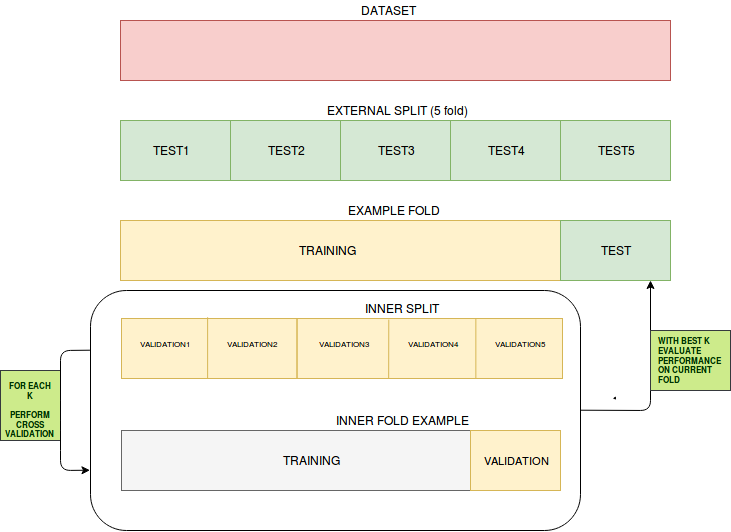 -->
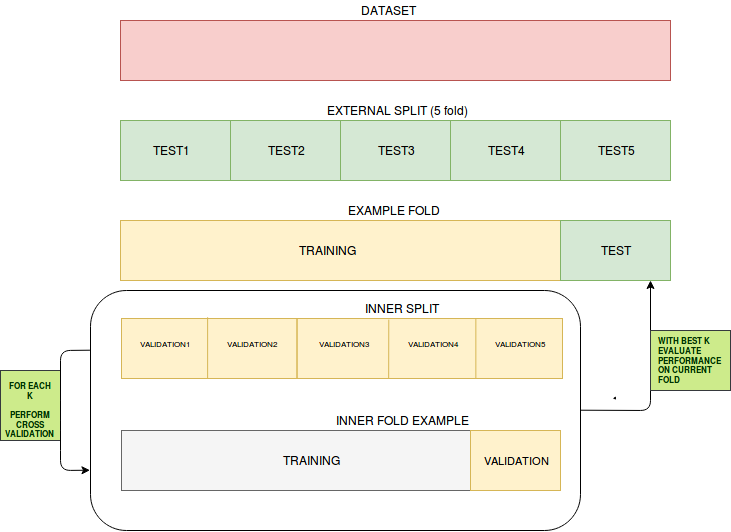
<center><b>Figure 2. Nested crossvalidation.</b> Source: <a href="https://stats.stackexchange.com/questions/319253/k-nearest-neighbors-with-nested-cross-validation">StackExchange</a></center>

### Grid search with crossvalidation

Let's start with basic grid search that is **not** nested.
Walking through this example will make it easier to understand the nested version.

First, let's make a workflow.
This workflow is identical to what we used for nonlinear SVM *except* that `cost` now has `tune()` as a parameter, and `tune()` will be a placeholder for different values during grid search:

- Set `recipe` to 
    - `pipe` with `recipes` do `recipe`
        - using `Species ~ .`
        - and `data = data_train`
    - to with `recipes` do `step_normalize`
        - using with `recipes` do `all_numeric_predictors`
- Set `model` to 
    - `pipe` with `parsnip` do `svm_rbf` 
        - using `cost =  tune()`
    - to with `parsnip` do `set_mode` 
        - using `"classification"`
    - then to with `parsnip` do `set_engine`
        - using `"kernlab"`
- Set `workflow` to 
    - `pipe` with `workflows` do `workflow`
    - to with `workflows` do `add_model`
        - using `model`
    - then to with `workflows` do `add_recipe` 
        - using `recipe`

In [154]:
recipe = recipes::recipe(Species ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::svm_rbf(cost =  tune()) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("kernlab")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="77" y="213"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Species ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="DEvi*v6Y{#}d{h35/S#3"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">svm_rbf</field><data>parsnip:svm_rbf</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="iP`lGU_Nf!$/q0V2={b8"><field name="CODE">cost =  tune()</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">kernlab</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value></block></next></block></next></block></xml>

Now we can pass the workflow to grid search.
We have the option of constructing a dataframe with various levels of `cost`, which we can do with the convenience function `base::expand.grid`, e.g. `expand.grid(cost = seq(.1,1,.2))` would create a dataframe of costs starting at .1 and moving towards 1 in increments of .2.
Alternatively, we can not specify anything and let grid_search choose values for us:

- Set `grid_search_results` to `pipe`
    - `workflow`
    - to with `tune` do `tune_grid`
        - using `resamples = folds`
        - and `metrics = metric_set(accuracy,precision,recall,f_meas)`
<!--         - and `control = control_grid(verbose = FALSE, save_pred = TRUE)` -->
- `print` `grid_search_results`

*Note we are giving grid search our original folds to work on, so it will build a model and calculate metrics using crossvalidation.*

In [ ]:
grid_search_results = workflow %>%
    tune::tune_grid(resamples = folds,metrics = metric_set(accuracy,precision,recall,f_meas))

print(grid_search_results);

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="2mpAJ#qVQ!+So89zduro">grid_search_results</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable></variables><block type="variables_set" id="-|(WC;3l+Su9Q$iC4++1" x="-264" y="54"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field><value name="VALUE"><block type="pipe_R" id="O7Wbjl||^O|(L#^lGI8_"><mutation items="1"></mutation><value name="INPUT"><block type="variables_get" id="Wo}jsOP(|#z3J`,n}cEr"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="IVB7o^iRWAZwD)z4|pEV"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">tune_grid</field><data>tune:tune_grid</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="}0|vrsP*^C/VFSO}6m!g"><field name="CODE">resamples = folds</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="yA*pSw4bWOe#)YDI2l@e"><field name="CODE">metrics = metric_set(accuracy,precision,recall,f_meas)</field></block></value></block></value></block></value></block><block type="text_print" id=";c4zSDs_,WkMrgIX;Ln." x="-254" y="262"><value name="TEXT"><shadow type="text" id="v|-SjxV9!fCG:uM;Ga2#"><field name="TEXT">abc</field></shadow><block type="variables_get" id="qZY6fZiS5bGgz1oTL.;6"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field></block></value></block><block type="dummyOutputCodeBlock_R" id="sb[)+UhGYRv85C8f`7E-" disabled="true" x="98" y="273"><field name="CODE">control = control_grid(verbose = FALSE, save_pred = TRUE)</field></block></xml>

We see familiar warnings about metrics like precision not being defined on some evaluation folds, which we can ignore at the moment.

Now we can request the best grid search results for each fold, according to our metric of interest.
Since we previously asked for multiple metrics, we could use any of them here:

- `with tune do show_best`
    - using `grid_search_results`
    - `metric = "f_meas"`

In [156]:
tune::show_best(grid_search_results,metric="f_meas")

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="2mpAJ#qVQ!+So89zduro">grid_search_results</variable></variables><block type="varDoMethod_R" id="yaFu4rAZ7=I6z?da?f5m" x="-162" y="220"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">show_best</field><data>tune:show_best</data><value name="ADD0"><block type="variables_get" id="SWfNE,}(^}{4cs?_LAZF"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="+*ZD.I3|~#Q$eP(pXp~["><field name="CODE">metric="f_meas"</field></block></value></block></xml>

cost,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2.5711784,f_meas,macro,0.9830688,10,0.01128748,Preprocessor1_Model09
0.9217249,f_meas,macro,0.9746032,10,0.01293143,Preprocessor1_Model03
10.1801512,f_meas,macro,0.9746032,10,0.01293143,Preprocessor1_Model04
0.3274036,f_meas,macro,0.9746032,10,0.01293143,Preprocessor1_Model08
17.2210708,f_meas,macro,0.9576720,10,0.01410935,Preprocessor1_Model01


The best results  of grid search for each fold are displayed, ranked by the metric, and the associated hyperparameter for `cost` is shown.
If we wanted to, we could choose the `cost` associated with the best performance, but of course this would lead to an overestimation of performance on the test data for the reasons discussed above.

### Example: Nested crossvalidation

We can implement nested crossvalidation for grid search somewhat simply by combining our approach from the section on crossvalidation and the last section on grid search.
To do this, we will have a loop that iterates over the outer folds, and within that loop, does grid search.
We'll save the results of the outer loop and the inner loop in two lists so we can analyze their results later.
This is a **really** big block of code, but much of it can be copy/pasted from cells above and then modified:

- Set `crossvalidation_list` to `create empty list`
- Set `grid_search_list` to `create empty list`
- Set `splits` to `with dplyr do pull`
    - using `folds`
    - and `splits`
- `for each item i in list` `splits`
    - `print` `i[[` `"id"` `]]` (Hint: this block is in LISTS)
    - Set `inner_folds` to `with rsample do vfold_cv`
        - using `with rsample do analysis`
            - using `i`
        - and `v=5`
        - and `strata="Species"`
    - Set `grid_search_results` to `pipe`
      - `workflow`
      - to with `tune` do `tune_grid`
          - using `resamples = folds`
          - and `metrics = metric_set(accuracy,precision,recall,f_meas)`
    - Set `inner_folds_best` to `with tune do show_best`
      - using `grid_search_results`
      - and `metric="f_meas"`
    - Set `grid_search_list` to ` with base do append` (save the inner crossvalidation result)
        - using `grid_search_list`
        - and `create list with` `inner_folds_best`
    - Set `best_cost` to `pipe` (get the best cost from grid search)
        - `inner_folds_best`
        - to with `dplyr` do `slice_head` (this gets the first row, which has the highest F1)
        - then to with `dplyr` do `pull` (this gets the numeric `cost` from the row)
            - using `cost`
    - Set `best_workflow` to `pipe` (create a new workflow with the best cost from grid search)
        - with `workflows` do `workflow`
        - to with `workflows` do `add_model`
          - using `pipe`
              -  with `parsnip` do `svm_rbf`
                  - using `cost =  best_cost`
              - then to with `parsnip` do `set_mode`
                  - using `"classification"`
              - then to with `parsnip` do `set_engine`
                  - using `"kernlab"`
        - then to with `workflows` do `add_recipe`
            - using `recipe`
    - Set `crossvalidation_list` to `with base do append` (save the new workflow result, which is the outer crossvalidation  result)
      - using `crossvalidation_list`
      - `pipe`
          - `best_workflow`
          - to with `generics` do `fit`
              - using `data = analysis(i)`
          - then to with `generics` do `augment`
              - using with `rsample` do `assessment`
                  - using `i`
          - then to with `yardstick` do `f_meas`
              - using `truth=Species`
              - and `estimate=.pred_class`
          - then to `create empty list`

In [ ]:
crossvalidation_list = list()
grid_search_list = list()
splits = dplyr::pull(folds,splits)
for (i in splits) {
  print(i[["id"]]);
  inner_folds = rsample::vfold_cv(rsample::analysis(i),v=5,strata="Species")
  grid_search_results = workflow %>%
      tune::tune_grid(resamples = folds,metrics = metric_set(accuracy,precision,recall,f_meas))
  inner_folds_best = tune::show_best(grid_search_results,metric="f_meas")
  grid_search_list = base::append(grid_search_list,list(inner_folds_best))
  best_cost = inner_folds_best %>%
      dplyr::slice_head() %>%
      dplyr::pull(cost)
  best_workflow = workflows::workflow() %>%
      workflows::add_model(parsnip::svm_rbf(cost =  best_cost) %>%
      parsnip::set_mode("classification") %>%
      parsnip::set_engine("kernlab")) %>%
      workflows::add_recipe(recipe)
  crossvalidation_list = base::append(crossvalidation_list,best_workflow %>%
      generics::fit(data = analysis(i)) %>%
      generics::augment(rsample::assessment(i)) %>%
      yardstick::f_meas(truth=Species,estimate=.pred_class) %>%
      list())
}

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</variable><variable id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</variable><variable id="K`{Hz~!9ZuG0HZx]xtEb">splits</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="%=F{E~)glz/Ed)+z[yb[">i</variable><variable id="Jf`Hc(Jw6)c^J2094GU-">folds</variable><variable id="|=7/P%?=Uxn2!yj0VEEx">inner_folds</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id="2mpAJ#qVQ!+So89zduro">grid_search_results</variable><variable id="qfFE]a![lf{?yV,L11~N">inner_folds_best</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="$ybdXEG(`9%z[8,F%0*D">best_cost</variable><variable id="112D;e=?c4oPp[3x2GfV">best_workflow</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable></variables><block type="variables_set" id="uo6KJ,h/mk3.:a{_:m.x" x="-307" y="-209"><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field><value name="VALUE"><block type="lists_create_with" id="`*2CC7.|arRQQ@*igTe1"><mutation items="0"></mutation></block></value><next><block type="variables_set" id="-b(D7MFQr6cL,wn?ek#K"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field><value name="VALUE"><block type="lists_create_with" id="4=)CS3C2^2@;$cunG?WO"><mutation items="0"></mutation></block></value><next><block type="variables_set" id="Nsq`(C)K}Z|9TeO{Qd`1"><field name="VAR" id="K`{Hz~!9ZuG0HZx]xtEb">splits</field><value name="VALUE"><block type="varDoMethod_R" id="Ur}KWOInYJJ:/~(VNr?#"><mutation items="2"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">pull</field><data>dplyr:pull</data><value name="ADD0"><block type="variables_get" id="vo-LwGPlPNNC7qEnRDW{"><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="c8LZ2,:E}Q1W92EE46Uz"><field name="CODE">splits</field></block></value></block></value><next><block type="controls_forEach" id="/^lHH-KTe%`Lz6%OE1I3"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field><value name="LIST"><block type="variables_get" id="PhxvKO;U]f4O6hbyOIQe"><field name="VAR" id="K`{Hz~!9ZuG0HZx]xtEb">splits</field></block></value><statement name="DO"><block type="text_print" id="yC$fZIfHp$?0k2L2Gk=9"><value name="TEXT"><shadow type="text" id="H-wq5|5mxW5UF9L9E2f5"><field name="TEXT">abc</field></shadow><block type="doubleIndexer_R" id=",^?=2mLu,?#$)b64CS^U"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field><value name="INDEX"><block type="text" id="}xC|(.Yj*eH0C-Z{0XHW"><field name="TEXT">id</field></block></value></block></value><next><block type="variables_set" id="PK.Z}:(86V@som|%~M;t"><field name="VAR" id="|=7/P%?=Uxn2!yj0VEEx">inner_folds</field><value name="VALUE"><block type="varDoMethod_R" id="MFk7be+oge:%k/]pa*,y"><mutation items="3"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">vfold_cv</field><data>rsample:vfold_cv</data><value name="ADD0"><block type="varDoMethod_R" id="^q`EP$:e[UI!Fl?sxqk,"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">analysis</field><data>rsample:analysis</data><value name="ADD0"><block type="variables_get" id="bQjS[l/B=FdX@f;?V.24"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="mph.C$CSmn`a)tZgv4Vb"><field name="CODE">v=5</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="]FJ1#d/*mD2p@N/tpA,B"><field name="CODE">strata="Species"</field></block></value></block></value><next><block type="variables_set" id="t!=8Yv-zy;M[pLt^f)fG"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field><value name="VALUE"><block type="pipe_R" id=".lL(]$@G+$Ji)$*ze|%c"><mutation items="1"></mutation><value name="INPUT"><block type="variables_get" id="7~aL+CU!wp%Vc!%0ikk9"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="N_+K_}Rp@aA(Mx)4n25$"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">tune_grid</field><data>tune:tune_grid</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=")#%[U#nF(,cH9VW((Uu7"><field name="CODE">resamples = folds</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="f`#pm5U@)1_;K^/-QbEr"><field name="CODE">metrics = metric_set(accuracy,precision,recall,f_meas)</field></block></value></block></value></block></value><next><block type="variables_set" id="FVrgEO4iQHQGK%L!vxWj"><field name="VAR" id="qfFE]a![lf{?yV,L11~N">inner_folds_best</field><value name="VALUE"><block type="varDoMethod_R" id="}!HBKcB^L`B!irj~AuJA"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">show_best</field><data>tune:show_best</data><value name="ADD0"><block type="variables_get" id="}xleUpG]QPPr3*h-a{7L"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="XP48r,b_fnwOXraE+C,L"><field name="CODE">metric="f_meas"</field></block></value></block></value><next><block type="variables_set" id=".z87IHr*3I#x-iR#hMC^"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field><value name="VALUE"><block type="varDoMethod_R" id="P0_lqGETL;Iig]?%h8-9"><mutation items="2"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">append</field><data>base:append</data><value name="ADD0"><block type="variables_get" id="SzQs.`/R)lgk22~U`O76"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field></block></value><value name="ADD1"><block type="lists_create_with" id="_4n[xK`9^|3o0WR|Ps/l"><mutation items="1"></mutation><value name="ADD0"><block type="variables_get" id="lxw~(bYyZL;;r0+aU(Ae"><field name="VAR" id="qfFE]a![lf{?yV,L11~N">inner_folds_best</field></block></value></block></value></block></value><next><block type="variables_set" id="i*o$E#!!hkt!Hnx^)Eg."><field name="VAR" id="$ybdXEG(`9%z[8,F%0*D">best_cost</field><value name="VALUE"><block type="pipe_R" id="*EQ]p,;GuoBv+ddVJhXg"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="1P=IPY0FJ2:):S:27$c,"><field name="VAR" id="qfFE]a![lf{?yV,L11~N">inner_folds_best</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="*LNOAMx?+oM807`:|.F)"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">slice_head</field><data>dplyr:slice_head</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="v*~]mPB=V-o]HY/Wy)aw"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">pull</field><data>dplyr:pull</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="|Nx{4;qJwKq}uy[WY0ck"><field name="CODE">cost</field></block></value></block></value></block></value><next><block type="variables_set" id="A@nb,})t*rhd(a8fXwf7"><field name="VAR" id="112D;e=?c4oPp[3x2GfV">best_workflow</field><value name="VALUE"><block type="pipe_R" id="ifOLvRhkDy+GOx+^du],"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="LRgWGx=mKjk3|#Kd6i2Q"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="nhc`+A_0ZGk);)z4,I4O"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="pipe_R" id="k}t0;Sb.`-I,|Auh%FiV"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="(0J$)W*BfSu|008}zYiX"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">svm_rbf</field><data>parsnip:svm_rbf</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="z+Pd^axrK:=b|}eFp{9^"><field name="CODE">cost =  best_cost</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Oxc%hyJ7zlPd?a?+dQ2k"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="/OQ.JCvlg4{|${Y%}bbP"><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="kXZZaY{A!SU::LY[L^9;"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="45*6V_|_VFQvtk}Yo||P"><field name="TEXT">kernlab</field></block></value></block></value></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="ya)4zP[~1)Y*7@dypy32"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="2OF^8bekFaG|C:BvRy.D"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value><next><block type="variables_set" id="7kzTps7v}Ty?rP%!tOK("><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field><value name="VALUE"><block type="varDoMethod_R" id="7-~zk_ThLQb,ln1=!{1C"><mutation items="2"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">append</field><data>base:append</data><value name="ADD0"><block type="variables_get" id="-Z@!ALv7NF-puwVZqP(^"><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field></block></value><value name="ADD1"><block type="pipe_R" id="2^lWRtZhY@8+qo`hRL#*"><mutation items="4"></mutation><value name="INPUT"><block type="variables_get" id="_`O#-W)5:|X=5G3bc`f/"><field name="VAR" id="112D;e=?c4oPp[3x2GfV">best_workflow</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="D%!ZoueYZ88-e|#Dv1@M"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="V;Ln7wyTLlGXEVPy3U|2"><field name="CODE">data = analysis(i)</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="r4|kwKgm,Y=YJYy2HDK|"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="varDoMethod_R" id="]+M11KQLOoeaP2)P==+p"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">assessment</field><data>rsample:assessment</data><value name="ADD0"><block type="variables_get" id="I?;e6mPuy:V~@P{Oe;~@"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field></block></value></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="O`=s_4(p+q6WGqzL(.I~"><mutation items="2"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="h)_Lxk+E.oef*pw1(ZC`"><field name="CODE">truth=Species</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="3Gcf7D4;#_VE1dbTz!2w"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="lists_create_with" id="{yaJ0ySD}wb1I!jb[Bax"><mutation items="0"></mutation></block></value></block></value></block></value></block></next></block></next></block></next></block></next></block></next></block></next></block></next></block></statement></block></next></block></next></block></next></block></xml>

Great, but how did it perform?
Let's plot the results we saved in `crossvalidation_list` and `grid_search_list`.

First, let's import `ggplot2` for plotting:

- `library ggplot2`

In [167]:
library(ggplot2)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="import_R" id="D4KG6vS$Jl7#22@e`gb}" x="-79" y="30"><field name="libraryName" id="K2WB)HAgulDnN4.esuaK">ggplot2</field></block></xml>

Now let's make a histogram using the F1 metrics we saved in `crossvalidation_list`.
Since `crossvalidation_list` is not a dataframe, we need to clean it up:

- `pipe`
    - `crossvalidation_list`
    - then to with `dplyr` do `bind_rows` (converts the list of dataframes into a single dataframe)
    - then to `make plot`
        - with `ggplot2` do `ggplot()`
        - and with `ggplot2` do `geom_histogram`
            - using `aes(x=.estimate)`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


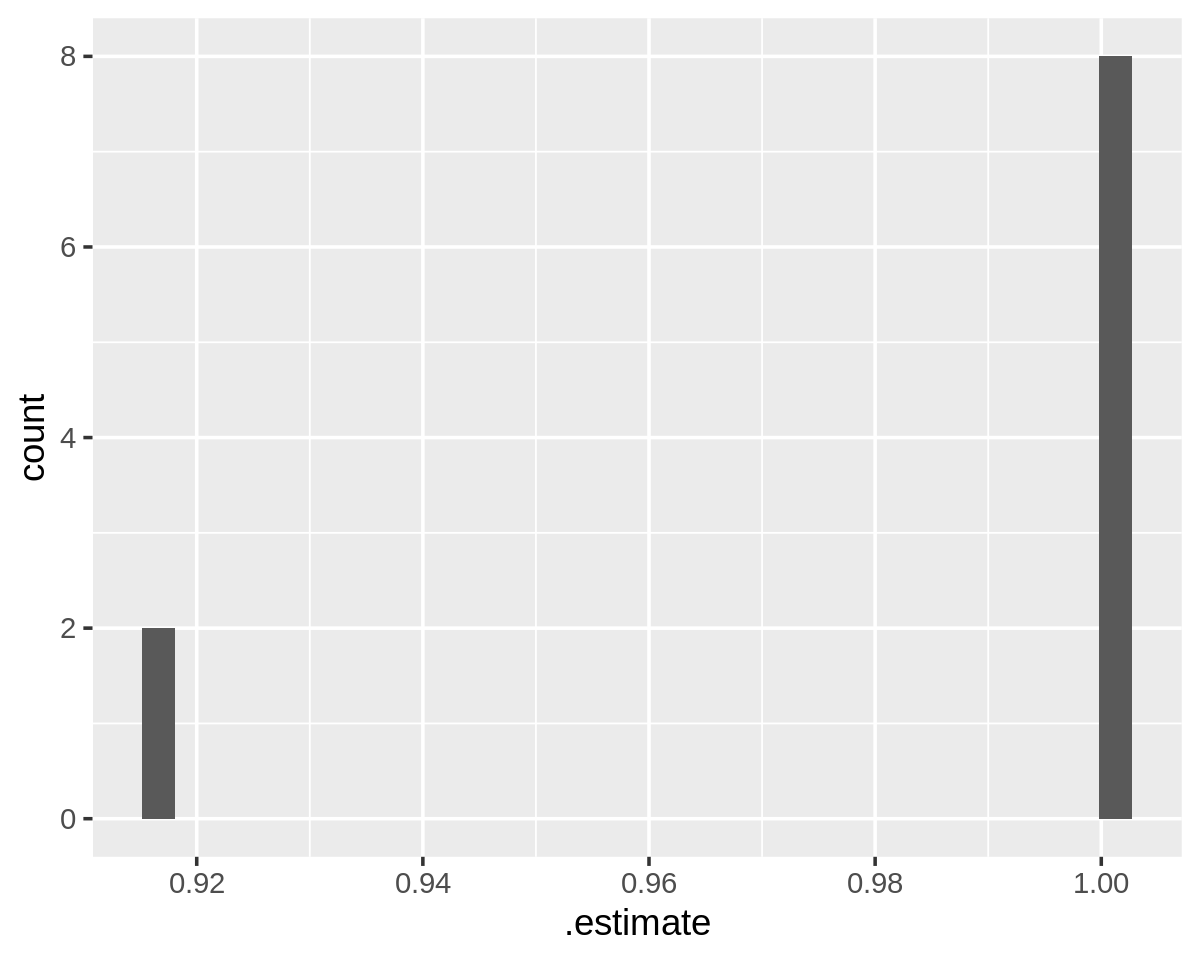

In [202]:
crossvalidation_list %>%
    dplyr::bind_rows() %>%
    ggplot2::ggplot() +
    ggplot2::geom_histogram(aes(x=.estimate))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="pipe_R" id="-blIJ8hlt6c^Bo(!]@R*" x="-364" y="114"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="#l(Cd*|f{@%iIwdIhga-"><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="s`K8^Pm9:9c{t~S|TT8R"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value><value name="ADD1"><block type="ggplot_plus_R" id="#rn:.wV-/JO._jJMh6DP"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="gE%7/}bvFYRw_,s?dNwn"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="m{RDZRT%HVfeM{Cw?[J4"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_histogram</field><data>ggplot2:geom_histogram</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="~:]~0vKFKYVr]/{It#t."><field name="CODE">aes(x=.estimate)</field></block></value></block></value></block></value></block></xml>

Since `crossvalidation_list` contains the F1 of the outer folds, this plot tells us that we are likely to get an F1 between .92 and 1.00 on the test data (and 1.00 is the most likely value).

Next we can make a plot for the `cost` parameter vs. mean F1 to see what different values of the `cost` parameter looked like across folds:

- `pipe`
    - `crossvalidation_list`
    - then to with `dplyr` do `bind_rows` 
    - then to `make plot`
        - with `ggplot2` do `ggplot()`
            - using `aes(x=.estimate)`
        - and with `ggplot2` do `geom_point`
        - and with `ggplot2` do `geom_jitter` (add some noise because our costs overlap)
        - and with `ggplot2` do `geom_smooth` (add a trend line to the scatterplot)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


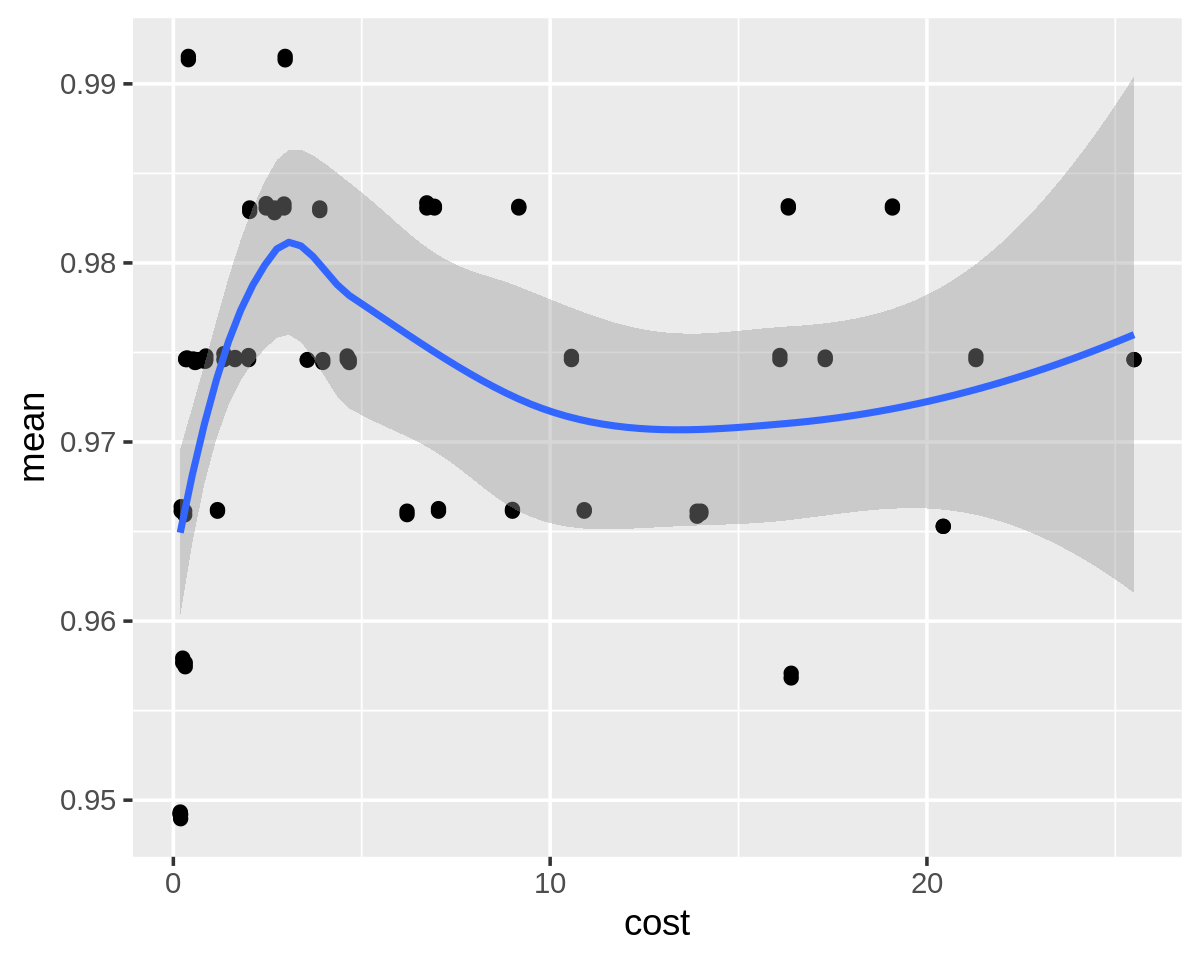

In [212]:
grid_search_list %>%
    dplyr::bind_rows() %>%
    ggplot2::ggplot(aes(x=cost,y=mean)) +
    ggplot2::geom_point() +
    ggplot2::geom_jitter() +
    ggplot2::geom_smooth()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="pipe_R" id="-blIJ8hlt6c^Bo(!]@R*" x="-359" y="110"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="#l(Cd*|f{@%iIwdIhga-"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="s`K8^Pm9:9c{t~S|TT8R"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value><value name="ADD1"><block type="ggplot_plus_R" id="#rn:.wV-/JO._jJMh6DP"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="gE%7/}bvFYRw_,s?dNwn"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="~:]~0vKFKYVr]/{It#t."><field name="CODE">aes(x=cost,y=mean)</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="m{RDZRT%HVfeM{Cw?[J4"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="[KC2z(J8-85uG%}mtIg]"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_jitter</field><data>ggplot2:geom_jitter</data></block></value><value name="ADD2"><block type="varDoMethod_R" id="lntCw5^JdnBq@jr%e]5|"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_smooth</field><data>ggplot2:geom_smooth</data></block></value></block></value></block></xml>

Based on the trendline, it seems our best `cost` will be around 3 or 4.

So it would be quite reasonable for us to refit a model with this `cost` and then evaluate against the test data.